In [1]:
from numba import jit,prange,stencil  #牢记prange也要导入
import numpy as np
import math

In [2]:
@jit(nopython=True,parallel=True)
def model_initial_state(MatA,MU,SIGMA): #MatA必须是一个numpy的array，MU和SIGMA分别表示高斯分布的均值与标准差
    row,col=MatA.shape #获取MatA的维度，并存于元组tuple
    for i in prange(row):
        for j in prange(col):
            RN=always_large_0(MU,SIGMA)
            MatA[i,j]=RN
    return MatA
    
@jit(nopython=True)
def always_large_0(MU,SIGMA):
    a=np.random.normal(MU,SIGMA)
    while a<0:
        a=np.random.normal(MU,SIGMA)
    return a

@jit(nopython=True)
def model_initial_evolution(MatB): #利用模型状态矩阵填充模型演化矩阵边界以内的区域
    row,col=MatB.shape
    MatA=np.empty((row+2,col+2))
    MatA[1:row+1,1:col+1]=MatB
    return MatA

@jit(nopython=True)
def model_evolution_update(MatA): #利用模型演化矩阵更新模型状态矩阵
    row,col=MatA.shape
    row=row-2
    col=col-2
    MatB=np.empty((row,col))
    MatB=MatA[1:row+1,1:col+1]
    return MatB

@jit(nopython=True) 
def periodic_boundary_condition(MatA,MatB): #利用模型状态矩阵边界填充模型演化矩阵的边界，实现周期边界条件
    row,col=MatB.shape
    MatA[0,1:col+1]=MatB[row-1,:]
    MatA[row+1,1:col+1]=MatB[0,:] 
    MatA[1:col+1,0]=MatB[:,col-1] 
    MatA[1:col+1,col+1]=MatB[:,0]
    MatA[0,0]=MatB[row-1,col-1]
    MatA[0,col+1]=MatB[row-1,0]
    MatA[row+1,0]=MatB[0,col-1]
    MatA[row+1,col+1]=MatB[0,0]
    return MatA

@jit(nopython=True)
def model_noise(row,col): #生成模型的噪音矩阵
    MatB=np.random.randn(row,col)
    MatA=model_initial_evolution(MatB)
    MatA=periodic_boundary_condition(MatA,MatB)
    return MatA

@stencil
def kernel_Global(MatA,MatB,par1,par2): #计算每个点受到的全局影响，MatA为模型演化矩阵，MatB为噪音矩阵，以点的视角编程
    return MatA[0,0]*math.exp(par1*(1-MatA[0,0]))*(1+par2*MatB[0,0])

@stencil
def kernel_Neighbour(MatA,MatB,par1,par2): #计算每个点受到的邻居影响，MatA为模型演化矩阵，MatB为噪音矩阵，以点的视角编程
    North=MatA[-1,0]*math.exp(par1*(1-MatA[-1,0]))*(1+par2*MatB[-1,0])
    South=MatA[1,0]*math.exp(par1*(1-MatA[1,0]))*(1+par2*MatB[1,0])
    East=MatA[0,1]*math.exp(par1*(1-MatA[0,1]))*(1+par2*MatB[0,1])
    West=MatA[0,-1]*math.exp(par1*(1-MatA[0,-1]))*(1+par2*MatB[0,-1])
    return North+South+East+West

In [3]:
def fun2():
    Burntime=np.int(0)
    T=np.int(10000)
    L=np.int(64)
    M=L  
    N=L
    LF=0.1 
    z=4.0 
    r=2.3  
    B=0.12 
    GF=1-LF
    LFR=LF/z
    dt=200
    modelstate=np.empty((M,N))
    MU=0.5
    SIGMA=0.1
    modelstate=model_initial_state(modelstate,MU,SIGMA)
    modelevolution=model_initial_evolution(modelstate)
    modelevolution=periodic_boundary_condition(modelevolution,modelstate)
    PreModelstate=modelstate
    PostModelstate=modelstate
    PreModelevolution=modelevolution
    PostModelevolution=modelevolution
    for k in range(Burntime+T): 
        PreModelstate=PostModelstate
        PreModelevolution=PostModelevolution
        evolutionNoise=model_noise(M,N)
        GlobalChange=kernel_Global(PreModelevolution,evolutionNoise,r,B)
        NeighbourChange=kernel_Neighbour(PreModelevolution,evolutionNoise,r,B)
        PostModelevolution=GF*GlobalChange+LFR*NeighbourChange
        PostModelstate=model_evolution_update(PostModelevolution)
        PostModelevolution=periodic_boundary_condition(PostModelevolution,PostModelstate)

In [ ]:
%timeit fun2() #10000步

In [4]:
Burntime=np.int(0)
T=np.int(500)
L=np.int(512)
M=L  
N=L
LF=0.1 
z=4.0 
r=2.3  
B=0.12 
GF=1-LF
LFR=LF/z
dt=200
modelstate=np.empty((M,N))
MU=0.5
SIGMA=0.1
modelstate=model_initial_state(modelstate,MU,SIGMA)
modelevolution=model_initial_evolution(modelstate)
modelevolution=periodic_boundary_condition(modelevolution,modelstate)
PreModelstate=modelstate
PostModelstate=modelstate
PreModelevolution=modelevolution
PostModelevolution=modelevolution
for k in range(Burntime+T): 
    PreModelstate=PostModelstate
    PreModelevolution=PostModelevolution
    evolutionNoise=model_noise(M,N)
    GlobalChange=kernel_Global(PreModelevolution,evolutionNoise,r,B)
    NeighbourChange=kernel_Neighbour(PreModelevolution,evolutionNoise,r,B)
    PostModelevolution=GF*GlobalChange+LFR*NeighbourChange
    PostModelstate=model_evolution_update(PostModelevolution)
    PostModelevolution=periodic_boundary_condition(PostModelevolution,PostModelstate)

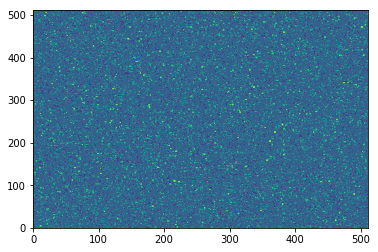

In [5]:
import matplotlib.pyplot as plt
fig=plt.figure()
plt.contourf(PostModelstate)
#plt.show()
plt.savefig('CPU.png',dpi=300)